<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Reconocimiento de Formas, 2024 - 2025 </b></div>

## **Clasificación de Animales: Keras Tuner**

In [1]:
!pip install keras_tuner --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import keras_tuner
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
keras.utils.set_random_seed(23)

Realizamos la lectura de los datos.

In [3]:
dataset_path = '/kaggle/input/animals10/raw-img'

IMG_SIZE = (64, 64)
BATCH_SIZE = 32
num_clases = 10

train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

test_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

validation_split = 0.25  
num_validation_batches = int(validation_split * len(train_dataset)) #.file_paths
validation_dataset = train_dataset.take(num_validation_batches)
train_dataset = train_dataset.skip(num_validation_batches)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


Definimos el espacio de busqueda para el keras tuner y realizamos las pruebas.

In [4]:
def build_model(hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=(64,64,3)))
    M.add(keras.layers.Rescaling(scale = 1/255))
    M.add(keras.layers.Flatten())
    for L in range(hp.Int("num_layers", 1, 5)):
        M.add(keras.layers.Dense(units=hp.Int(f"units_{L}", min_value=64, max_value=4096, step=4, sampling="log"),
        activation='relu'))
    M.add(keras.layers.Dense(10, activation='softmax'))
    M.compile(loss="SparseCategoricalCrossentropy", optimizer="adam", metrics=["SparseCategoricalAccuracy"])
    return M

In [5]:
tuner = keras_tuner.BayesianOptimization(
 hypermodel = build_model,
 objective = "val_SparseCategoricalAccuracy",
 max_trials = 15, 
 executions_per_trial = 1,
 overwrite = True
)

In [6]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 4096, 'step': 4, 'sampling': 'log'}


In [7]:
tuner.search(train_dataset, batch_size = BATCH_SIZE, epochs = 15, validation_data = validation_dataset)

Trial 15 Complete [00h 03m 05s]
val_SparseCategoricalAccuracy: 0.18769171833992004

Best val_SparseCategoricalAccuracy So Far: 0.3702070415019989
Total elapsed time: 00h 48m 20s


In [8]:
tuner.results_summary(num_trials = 3)

Results summary
Results in ./untitled_project
Showing 3 best trials
Objective(name="val_SparseCategoricalAccuracy", direction="max")

Trial 01 summary
Hyperparameters:
num_layers: 4
units_0: 4096
units_1: 256
units_2: 64
units_3: 64
Score: 0.3702070415019989

Trial 12 summary
Hyperparameters:
num_layers: 5
units_0: 256
units_1: 256
units_2: 64
units_3: 256
units_4: 256
Score: 0.3512269854545593

Trial 03 summary
Hyperparameters:
num_layers: 5
units_0: 256
units_1: 64
units_2: 4096
units_3: 256
units_4: 64
Score: 0.34835124015808105


In [9]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 1.838
Precisión: 36.8%


In [10]:
M = build_model(tuner.get_best_hyperparameters(1)[0])
H = M.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 30, verbose=1, validation_data=validation_dataset)

Epoch 1/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - SparseCategoricalAccuracy: 0.1741 - loss: 4.3388 - val_SparseCategoricalAccuracy: 0.2433 - val_loss: 2.1682
Epoch 2/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - SparseCategoricalAccuracy: 0.2336 - loss: 2.1063 - val_SparseCategoricalAccuracy: 0.2784 - val_loss: 2.0225
Epoch 3/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - SparseCategoricalAccuracy: 0.2775 - loss: 2.0162 - val_SparseCategoricalAccuracy: 0.3066 - val_loss: 1.9926
Epoch 4/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - SparseCategoricalAccuracy: 0.2983 - loss: 1.9590 - val_SparseCategoricalAccuracy: 0.3196 - val_loss: 1.9287
Epoch 5/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - SparseCategoricalAccuracy: 0.3067 - loss: 1.9170 - val_SparseCategoricalAccuracy: 0.3303 - val_loss: 1.9010
Epoch 6/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - SparseCategoricalAccuracy: 0.3279 - loss: 1.8818 - val_SparseCategoricalAccuracy: 0.3263 - val_loss: 1.9107
Epoch 7/30
492/4

In [12]:
score = M.evaluate(test_dataset, verbose = 0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.1%}')

Loss: 2.119
Precisión: 37.1%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

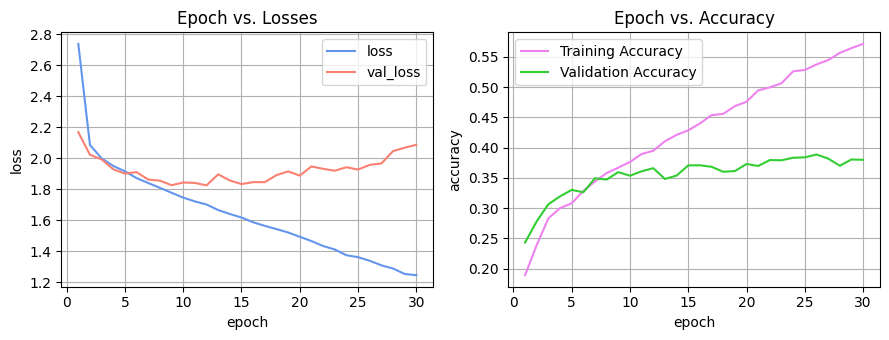

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
# ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
# ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

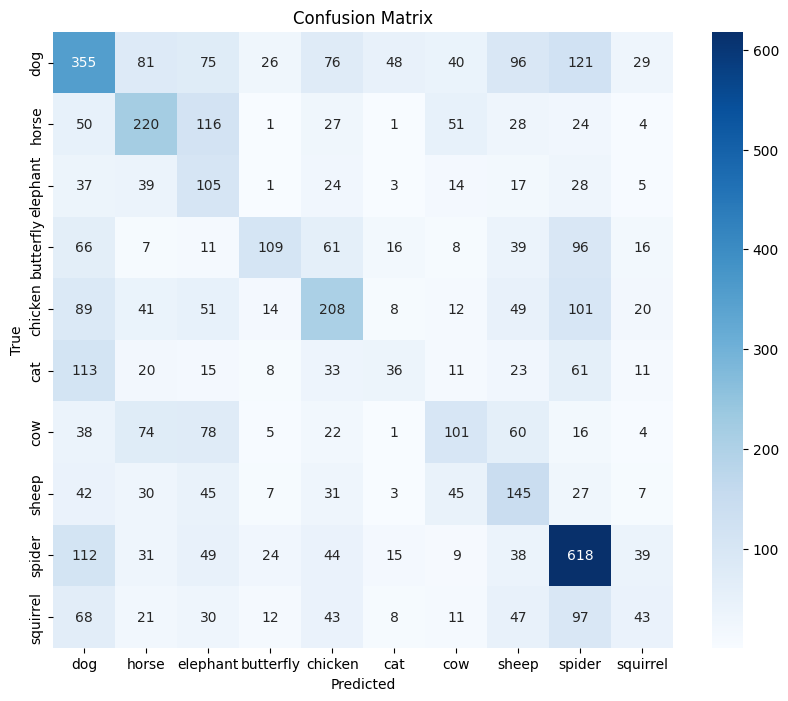

              precision    recall  f1-score   support

         dog       0.37      0.37      0.37       947
       horse       0.39      0.42      0.41       522
    elephant       0.18      0.38      0.25       273
   butterfly       0.53      0.25      0.34       429
     chicken       0.37      0.35      0.36       593
         cat       0.26      0.11      0.15       331
         cow       0.33      0.25      0.29       399
       sheep       0.27      0.38      0.31       382
      spider       0.52      0.63      0.57       979
    squirrel       0.24      0.11      0.15       380

    accuracy                           0.37      5235
   macro avg       0.35      0.33      0.32      5235
weighted avg       0.38      0.37      0.36      5235



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

## **Resumen de Resultados**

- Con el MLP sencillo obtenemos una precisión del 36.6%.
- Usando el Keras Tuner para la arquitectura de red obtenemos una precisión del 37.1%, se produce una leve mejora y podemos ver como el f1-score en general llega a valores más altos con una arquitectura de tres capas de 4096, 256 y 64 neuronas respectivamente.